In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib_venn import venn3
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles

import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries
from skimage.filters import threshold_li, threshold_otsu
import pyBigWig
from scipy import linalg
from scipy.signal import argrelextrema
import csv

cooltools.__version__

<ipython-input-1-f8ebe3510ca0>:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


'0.4.0'

In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

def cgi_region(clr,region):
    cg = adaptive_coarsegrain(clr.matrix(balance=True).fetch(region),
                              clr.matrix(balance=False).fetch(region),
                              cutoff=3, max_levels=8)
    cgi = interp_nan(cg)
    return(cgi)

def bed3_mids(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index()
    mid = (a['start']+a['end'])//2
    b = mid[(mid > start) & (mid < end)]
    return(np.array(b))

def bed3_mids2(bed3plus,chrom,start,end):
    a = bed3plus[bed3plus['chrom']==chrom].reset_index(drop=True)
    mid = (a['start']+a['end'])//2
    b = a[(mid > start) & (mid < end)].iloc[:,[0,1,2]]
    return(b.reset_index(drop=True))

def add_mid(input):
    input['chrom']=input['chrom'].str.replace('chr','')
    input['mid']=(input.end+input.start)//2
    return input

def add_windows(input,region):
    w = snipping.make_bin_aligned_windows(
        resolution,
        input['chrom'],input['mid'],flank_bp=flank)
    w['strand']='.'
#    w['region'] = ce10_X['name'][0]
    w = snipping.assign_regions(w, region)
    return w

nthreads=4
def my_pup_clr(clr,windows,regions):
    clr_snipper = cooltools.snipping.CoolerSnipper(clr, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        clr_stack = cooltools.snipping.pileup(
            windows,
            clr_snipper.select,
            clr_snipper.snip,
            map=pool.map
            )
    clr_avg = np.nanmean(clr_stack, axis=2)
    return clr_avg

def my_expected(clr,regions):
    with multiprocess.Pool(nthreads) as pool:
        expected = cooltools.expected.diagsum(
            clr,
            regions=regions,
            transforms={
                'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
            },
            map=pool.map
        )
    expected['balanced.avg'] = expected['balanced.sum'] / expected['n_valid']
    return(expected)

def my_pup_oe(clr,windows,regions,expected):
    expected_snipper = cooltools.snipping.ObsExpSnipper(clr, expected, regions=regions)
    with multiprocess.Pool(nthreads) as pool:
        oe_stack = cooltools.snipping.pileup(
            windows,
            expected_snipper.select,
            expected_snipper.snip,
            map=pool.map
        )
    expected_avg = np.nanmean(oe_stack, axis=2)
    return expected_avg

def bwTobedMatrix(bw,region,nbins):
    lst_region = [region['start'],region['end']]
    lst_bw = []
    for i in range(0,len(lst_region[0])):
        chrom = "".join(['chr', region['chrom'][i]]) # bw uses 'chrI', my bed uses 'I'
        if lst_region[1].reset_index(drop=True)[i] < bw.chroms(chrom):
            if lst_region[0].reset_index(drop=True)[i] > 0:
                v = bw.stats(chrom,
                             lst_region[0].reset_index(drop=True)[i],
                             lst_region[1].reset_index(drop=True)[i],
                             type='mean',nBins=nbins)
            
                lst_bw.append(pd.to_numeric(v,errors='coerce'))
    return(lst_bw)

def InsLocalMax(coolr, windowSize, method):
    x = calculate_insulation_score(coolr, windowSize, verbose=False)
    val = x["log2_insulation_score_"+str(windowSize)].apply(lambda x: x*-1)
    
    x_1 = x[['chrom','start','end','is_bad_bin',"n_valid_pixels_"+str(windowSize)]]
    x_2 = pd.concat([x_1,val],axis=1).reindex(x_1.index)
    y = find_boundaries(x_2,log2_ins_key="log2_insulation_score_"+str(windowSize),
                        n_valid_pixels_key="n_valid_pixels_"+str(windowSize))
    
    if method=='otsu':
        print('otsu')
        t = threshold_otsu(y['boundary_strength'].dropna().values)
    if method =='li':
        print('li')
        t = threshold_li(y['boundary_strength'].dropna().values)
    t_1 = y[y['boundary_strength']>t]    
    print(len(t_1.index))    
    return y,t_1


def InsLocalMax_ofdiff_AminusB(coolrA,coolrB, windowSize, method):
    a = calculate_insulation_score(coolrA, windowSize, verbose=False)
    b = calculate_insulation_score(coolrB, windowSize, verbose=False)
    diff = b[["log2_insulation_score_"+str(windowSize)]]-a[["log2_insulation_score_"+str(windowSize)]]
    a_1 = a[['chrom','start','end','is_bad_bin',"n_valid_pixels_"+str(windowSize)]]
    a_2 = pd.concat([a_1, diff], axis=1).reindex(a_1.index)
    y = find_boundaries(a_2,log2_ins_key="log2_insulation_score_"+str(windowSize),
                        n_valid_pixels_key="n_valid_pixels_"+str(windowSize))
    
    if method=='otsu':
        print('otsu')
        t = threshold_otsu(y['boundary_strength'].dropna().values)
    if method =='li':
        print('li')
        t = threshold_li(y['boundary_strength'].dropna().values)
    t_1 = y[y['boundary_strength']>t]    
    print(len(t_1.index))
    return y,t_1

def QuantilesPandas(dat,Colname):
    boundaryS = dat[Colname]
    q1 = np.quantile(boundaryS,0.25)
    q2 = np.quantile(boundaryS,0.5)
    q3 = np.quantile(boundaryS,0.75)
    #print(q1,q2,q3)
    grp1 = dat[boundaryS<q1]
    grp2 = dat[np.logical_and(boundaryS>=q1, boundaryS<q2)]
    grp3 = dat[np.logical_and(boundaryS>=q2, boundaryS<q3)]
    grp4 = dat[boundaryS>=q3]
    return grp1,grp2,grp3,grp4


def scaling_agg(input_clr,input_regions):
    cvd = cooltools.expected.diagsum(
        clr=input_clr,
        regions=input_regions,
        transforms={'balanced': lambda p: p['count']*p['weight1']*p['weight2']}
    )
    lb_cvd, lb_slopes, lb_distbins = cooltools.expected.logbin_expected(cvd)
    lb_cvd_agg, lb_slopes_agg = cooltools.expected.combine_binned_expected(
        lb_cvd,
        binned_exp_slope=lb_slopes
    )
    lb_cvd_agg['s_bp'] = lb_cvd_agg['diag.avg'] * input_clr.binsize
    lb_slopes_agg['s_bp'] = lb_slopes_agg['diag.avg'] * input_clr.binsize
    x = np.array(lb_slopes_agg['s_bp'])
    y = np.array(lb_slopes_agg['slope'])
    loop_size = x[argrelextrema(y, np.greater)]
    LocalMins = x[argrelextrema(y, np.less)]
    return(lb_cvd_agg,lb_slopes_agg,loop_size,LocalMins)


In [3]:
ce10=bioframe.read_table('/home/kimj50/ce10.chrom.sizes',schema='bed3')
ce10=bioframe.parse_regions(ce10)

INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
# clrs
res = '2000'
clr_notag = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK07_JK08_30_"+res+"_raw.cool")
clr_smc3 = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK153_JK180_30_"+res+"_raw.cool")
clr_wapl = cooler.Cooler("/scratch/cgsb/ercan/juicerToh5_2021/hicTocool_raw/JK155_combined_JK181_30_"+res+"_raw.cool")

clrs = [clr_notag,clr_smc3,clr_wapl]

In [5]:
def jetcaller_v5(clrs_lst,W,Method):
    a = InsLocalMax_ofdiff_AminusB(coolrA=clrs_lst[0],coolrB=clrs_lst[1],windowSize=W,method=Method)
    b = InsLocalMax(clrs_lst[0],W,method=Method)
    c = InsLocalMax(clrs_lst[2],W,method=Method)
    
    raw_out = [a,b,c]
    
    # a,b intersect
    a_b = bioframe.closest(a[1],b[1])
    a_b_1 = a_b[a_b['distance']<(W/2)]
    a_b_2 = a_b_1.loc[:,['chrom_1','start_1','end_1','boundary_strength_1']]
    a_b_2.rename(columns={'chrom_1':'chrom','start_1':'start','end_1':'end','boundary_strength_1':'boundary_strength'},inplace=True)
    
    # ab, c intersect
    ab_c = bioframe.closest(a_b_2,c[1])
    ab_c_1 = ab_c[ab_c['distance']<(W/2)]
    ab_c_2 = ab_c_1.loc[:,['chrom_1','start_1','end_1','boundary_strength_1']]
    ab_c_2.rename(columns={'chrom_1':'chrom','start_1':'start','end_1':'end','boundary_strength_1':'boundary_strength'},inplace=True)
    
    # venn diagram
    s1 = (len(a[1])-len(a_b_1),len(b[1])-len(a_b_1),len(a_b_1))
    s2 = (len(a_b_1)-len(ab_c_1),len(c[1])-len(ab_c_1),len(ab_c_1))
    
    return(raw_out,ab_c_2,[s1,s2])

t = jetcaller_v5(clrs,30000,'otsu')

otsu
831
otsu
449
otsu
587


In [7]:
t[1].to_csv('./jetcall_v5_w30kb.bed',sep='\t',header=False,index=False)

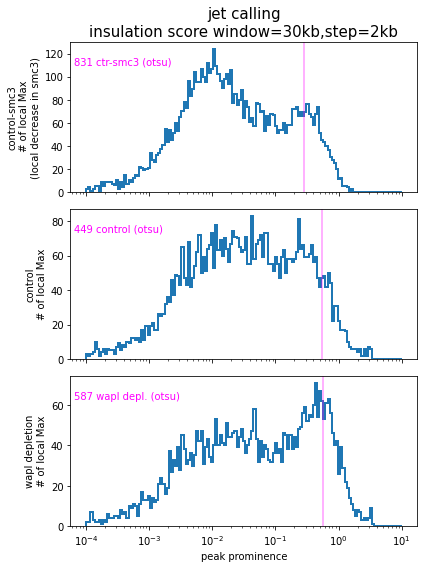

In [8]:
dat = t[0]

histkwargs = dict(
    bins=10**np.linspace(-4,1,150),
    histtype='step',
    lw=2,
)
f, axs = plt.subplots(
    figsize=(6,8),
    nrows = 3,
    ncols = 1,
    sharex=True
)
#ylabels = 5*['# of maxima']
ylabels = ['control-smc3\n # of local Max\n(local decrease in smc3)',
           'control\n# of local Max',
           'wapl depletion\n# of local Max']

textLabels = ['ctr-smc3','control','wapl depl.']
Alpha=0.4

for i in range(len(dat)):
    val = dat[i][0]['boundary_strength']
    t_li = threshold_li(val.dropna().values)
    t_otsu = threshold_otsu(val.dropna().values)
    n_boundaries_li = (val.dropna()>t_li).sum()
    n_boundaries_otsu = (val.dropna()>t_otsu).sum()

    ax=axs[i]
    ax.hist(
        val,**histkwargs)
#    ax.axvline(t_li, c='green',alpha=Alpha)
    ax.axvline(t_otsu, c='magenta',alpha=Alpha)

#    ax.text(0.01, 0.9,
#            f'{n_boundaries_li} '+textLabels[i]+' (li)',
#            c='green',
#            ha='left',
#            va='top',
#            transform=ax.transAxes)
    ax.text(0.01, 0.9,
            f'{n_boundaries_otsu} '+textLabels[i]+' (otsu)',
            c='magenta',
            ha='left',
            va='top',
            transform=ax.transAxes)
        
        

    axs[i].set(
        ylabel=ylabels[i]
    )
ax.set(
    xscale='log',
    xlabel='peak prominence'
)
axs[0].set_title('jet calling\ninsulation score window=30kb,step=2kb',size=15)

plt.tight_layout()

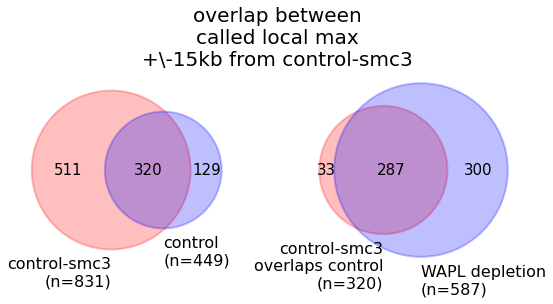

In [9]:
### n peaks, center
f, axs = plt.subplots(
    figsize=(8, 4),
    nrows=1,
    ncols=2,
    sharey='row'
)

# (Ab,aB,AB)

dat = t[2]

i = 0
c = venn2(ax=axs[i], subsets = dat[i],
          set_labels = ('control-smc3\n(n='+str(dat[i][2]+dat[i][0])+')',
                        'control\n(n='+str(dat[i][2]+dat[i][1])+')'),alpha=0)
circles = venn2_circles(ax=axs[i],subsets = dat[i])
for circle, color in zip(circles, ['red', 'blue']):
    circle.set_lw(2.0)
    circle.set_alpha(0.25)
    circle.set_color(color)
for text in c.set_labels:
    text.set_fontsize(16)
for text in c.subset_labels:
    text.set_fontsize(15)
        
i = 1
c = venn2(ax=axs[i], subsets = dat[i],
          set_labels = ('control-smc3\noverlaps control\n(n='+str(dat[i][2]+dat[i][0])+')',
                        'WAPL depletion\n(n='+str(dat[i][2]+dat[i][1])+')'),alpha=0)
circles = venn2_circles(ax=axs[i],subsets = dat[i])
for circle, color in zip(circles, ['red', 'blue']):
    circle.set_lw(2.0)
    circle.set_alpha(0.25)
    circle.set_color(color)
for text in c.set_labels:
    text.set_fontsize(16)
for text in c.subset_labels:
    text.set_fontsize(15)
        
        
        
        

f.text(0.5, 0.88, 'overlap between\ncalled local max\n+\-15kb from control-smc3', ha='center',fontsize=20)

#f.text(0.73, 0.83, 'overlapping\nlocal max', ha='center',fontsize=20)

plt.tight_layout()